| **Chapter**                   | 9:  Agent-based modeling                       |
| ----------------------------- |------------------------------------------------|
| **Computational Note**        | 9.x: An ABM for pure vector-borne disease      |
| **Package prerequisites**     | [Mesa](https://mesa.readthedocs.io/en/latest/) |


# An ABM for pure vector-borne disease

In [1]:
import numpy as np
import pandas as pd
from mesa import Agent, Model
from mesa.time import RandomActivation
from mesa.space import MultiGrid
from mesa.datacollection import DataCollector
from mesa import batchrunner
from matplotlib import pyplot as plt
import random
import networkx as nx
import json
from scipy import stats
import enum


COLORS = {"S": "#2f4b7c",
          "E": "#ffa600",
          "I": "#f95d6a",
          "R": "#a05195",
          "D": "#003f5c",
          "C": "#ff7c43",
          "X": "#665191",
          "Y": "#d45087"}

In [2]:
class State(enum.IntEnum):
    SUSCEPTIBLE = 0
    INFECTED = 1
    RECOVERED = 2
    DECEASED = 3

In [3]:
class Host(Agent):
    def __init__(self, uid, model):
        super().__init__(uid, model)
        self.state = State.SUSCEPTIBLE
        self.type = "host"

    def status_update(self):
        if self.state == State.INFECTED:
            if np.random.rand() < 1/(1 + 32 * self.model.recovery_period.rvs()):
                if np.random.rand() < self.model.CFR:
                    self.state = State.DECEASED
                else:
                    self.state = State.RECOVERED

        if np.random.rand() < self.model.host_mortality_rate:
            self.state = State.DECEASED

    def step(self):
        self.status_update()

class Vector(Agent):
    def __init__(self, uid, model):
        super().__init__(uid, model)
        self.state = State.SUSCEPTIBLE
        self.type = "vector"

    def contact_event(self):
        neighbouring_hosts = [agent for agent in self.model.grid.get_neighbors(self.pos, include_center=True, moore=True) if isinstance(agent, Host)]
        
        if len(neighbouring_hosts) > 0:
            target = random.choice(neighbouring_hosts)
        
            if target.state is State.INFECTED and self.state is State.SUSCEPTIBLE:
                self.state = State.INFECTED
            elif target.state is State.SUSCEPTIBLE and self.state is State.INFECTED:
                target.state = State.INFECTED

    def step(self):
        self.contact_event()

        if np.random.rand() < self.model.vector_mortality_rate:
            self.state = State.DECEASED

In [4]:
class HostVectorModel(Model):
    def __init__(self, 
                 N_host,
                 N_vector,
                 width=10, 
                 height=10,
                 recovery_period=stats.beta(4, 8),
                 CFR=0.05,
                 host_mortality_rate=0.000125,
                 vector_mortality_rate=0.0125,
                 vector_birth_rate=0.02,
                 I0_host=0.075,
                 I0_vector=0.3):
        
        self.N_vector = N_vector
        self.recovery_period = recovery_period
        self.CFR = CFR
        self.host_mortality_rate = host_mortality_rate
        self.vector_mortality_rate = vector_mortality_rate
        self.vector_birth_rate = vector_birth_rate
        self.grid = MultiGrid(width, height, torus=True)
        self.schedule = RandomActivation(self)
        self.running = True

        self.datacollector = DataCollector(agent_reporters={"State": "state", "Type": "type"})

        for i in range(N_host):
            agent = Host(f"h_{i}", self)

            if np.random.rand() < I0_host:
                agent.state = State.INFECTED

            self.schedule.add(agent)
            x = np.random.randint(0, self.grid.width)
            y = np.random.randint(0, self.grid.height)
            self.grid.place_agent(agent, (x, y))

        for i in range(N_vector):
            agent = Vector(f"v_{i}", self)

            if np.random.rand() < I0_vector:
                agent.state = State.INFECTED

            self.schedule.add(agent)
            x = np.random.randint(0, self.grid.width)
            y = np.random.randint(0, self.grid.height)
            self.grid.place_agent(agent, (x, y))

    def step(self):
        for i in range(self.N_vector):
            if np.random.rand() < self.vector_birth_rate:
                agent = Vector(f"v_{len(self.schedule.agents) + 1}", self)
                self.schedule.add(agent)
                x = np.random.randint(0, self.grid.width)
                y = np.random.randint(0, self.grid.height)
                self.grid.place_agent(agent, (x, y))

        self.datacollector.collect(self)
        self.schedule.step()

In [5]:
br = batchrunner.FixedBatchRunner(HostVectorModel,
                                  fixed_parameters={"N_host": 1000, "N_vector": 10000},
                                  iterations=3,
                                  max_steps=120,
                                  model_reporters={"vals": lambda m: m.datacollector},
                                  display_progress=True)

In [6]:
br.run_all()

3it [28:40, 573.43s/it]


In [7]:
host_df = pd.concat(list(
    map(lambda x: pd.pivot_table(x[x.Type=="host"].reset_index()[["Step", "AgentID", "State"]], 
        index="Step", 
        columns="State", 
        aggfunc=np.size).T.reset_index(level=0, drop=True).T[1].T,
    [br.get_model_vars_dataframe()["vals"][i].get_agent_vars_dataframe() for i in range(len(br.get_model_vars_dataframe()["vals"]))])
), axis=1)

In [8]:
vector_df = pd.concat(list(
    map(lambda x: pd.pivot_table(x[x.Type=="vector"].reset_index()[["Step", "AgentID", "State"]], 
        index="Step", 
        columns="State", 
        aggfunc=np.size).T.reset_index(level=0, drop=True).T[1].T,
    [br.get_model_vars_dataframe()["vals"][i].get_agent_vars_dataframe() for i in range(len(br.get_model_vars_dataframe()["vals"]))])
), axis=1)

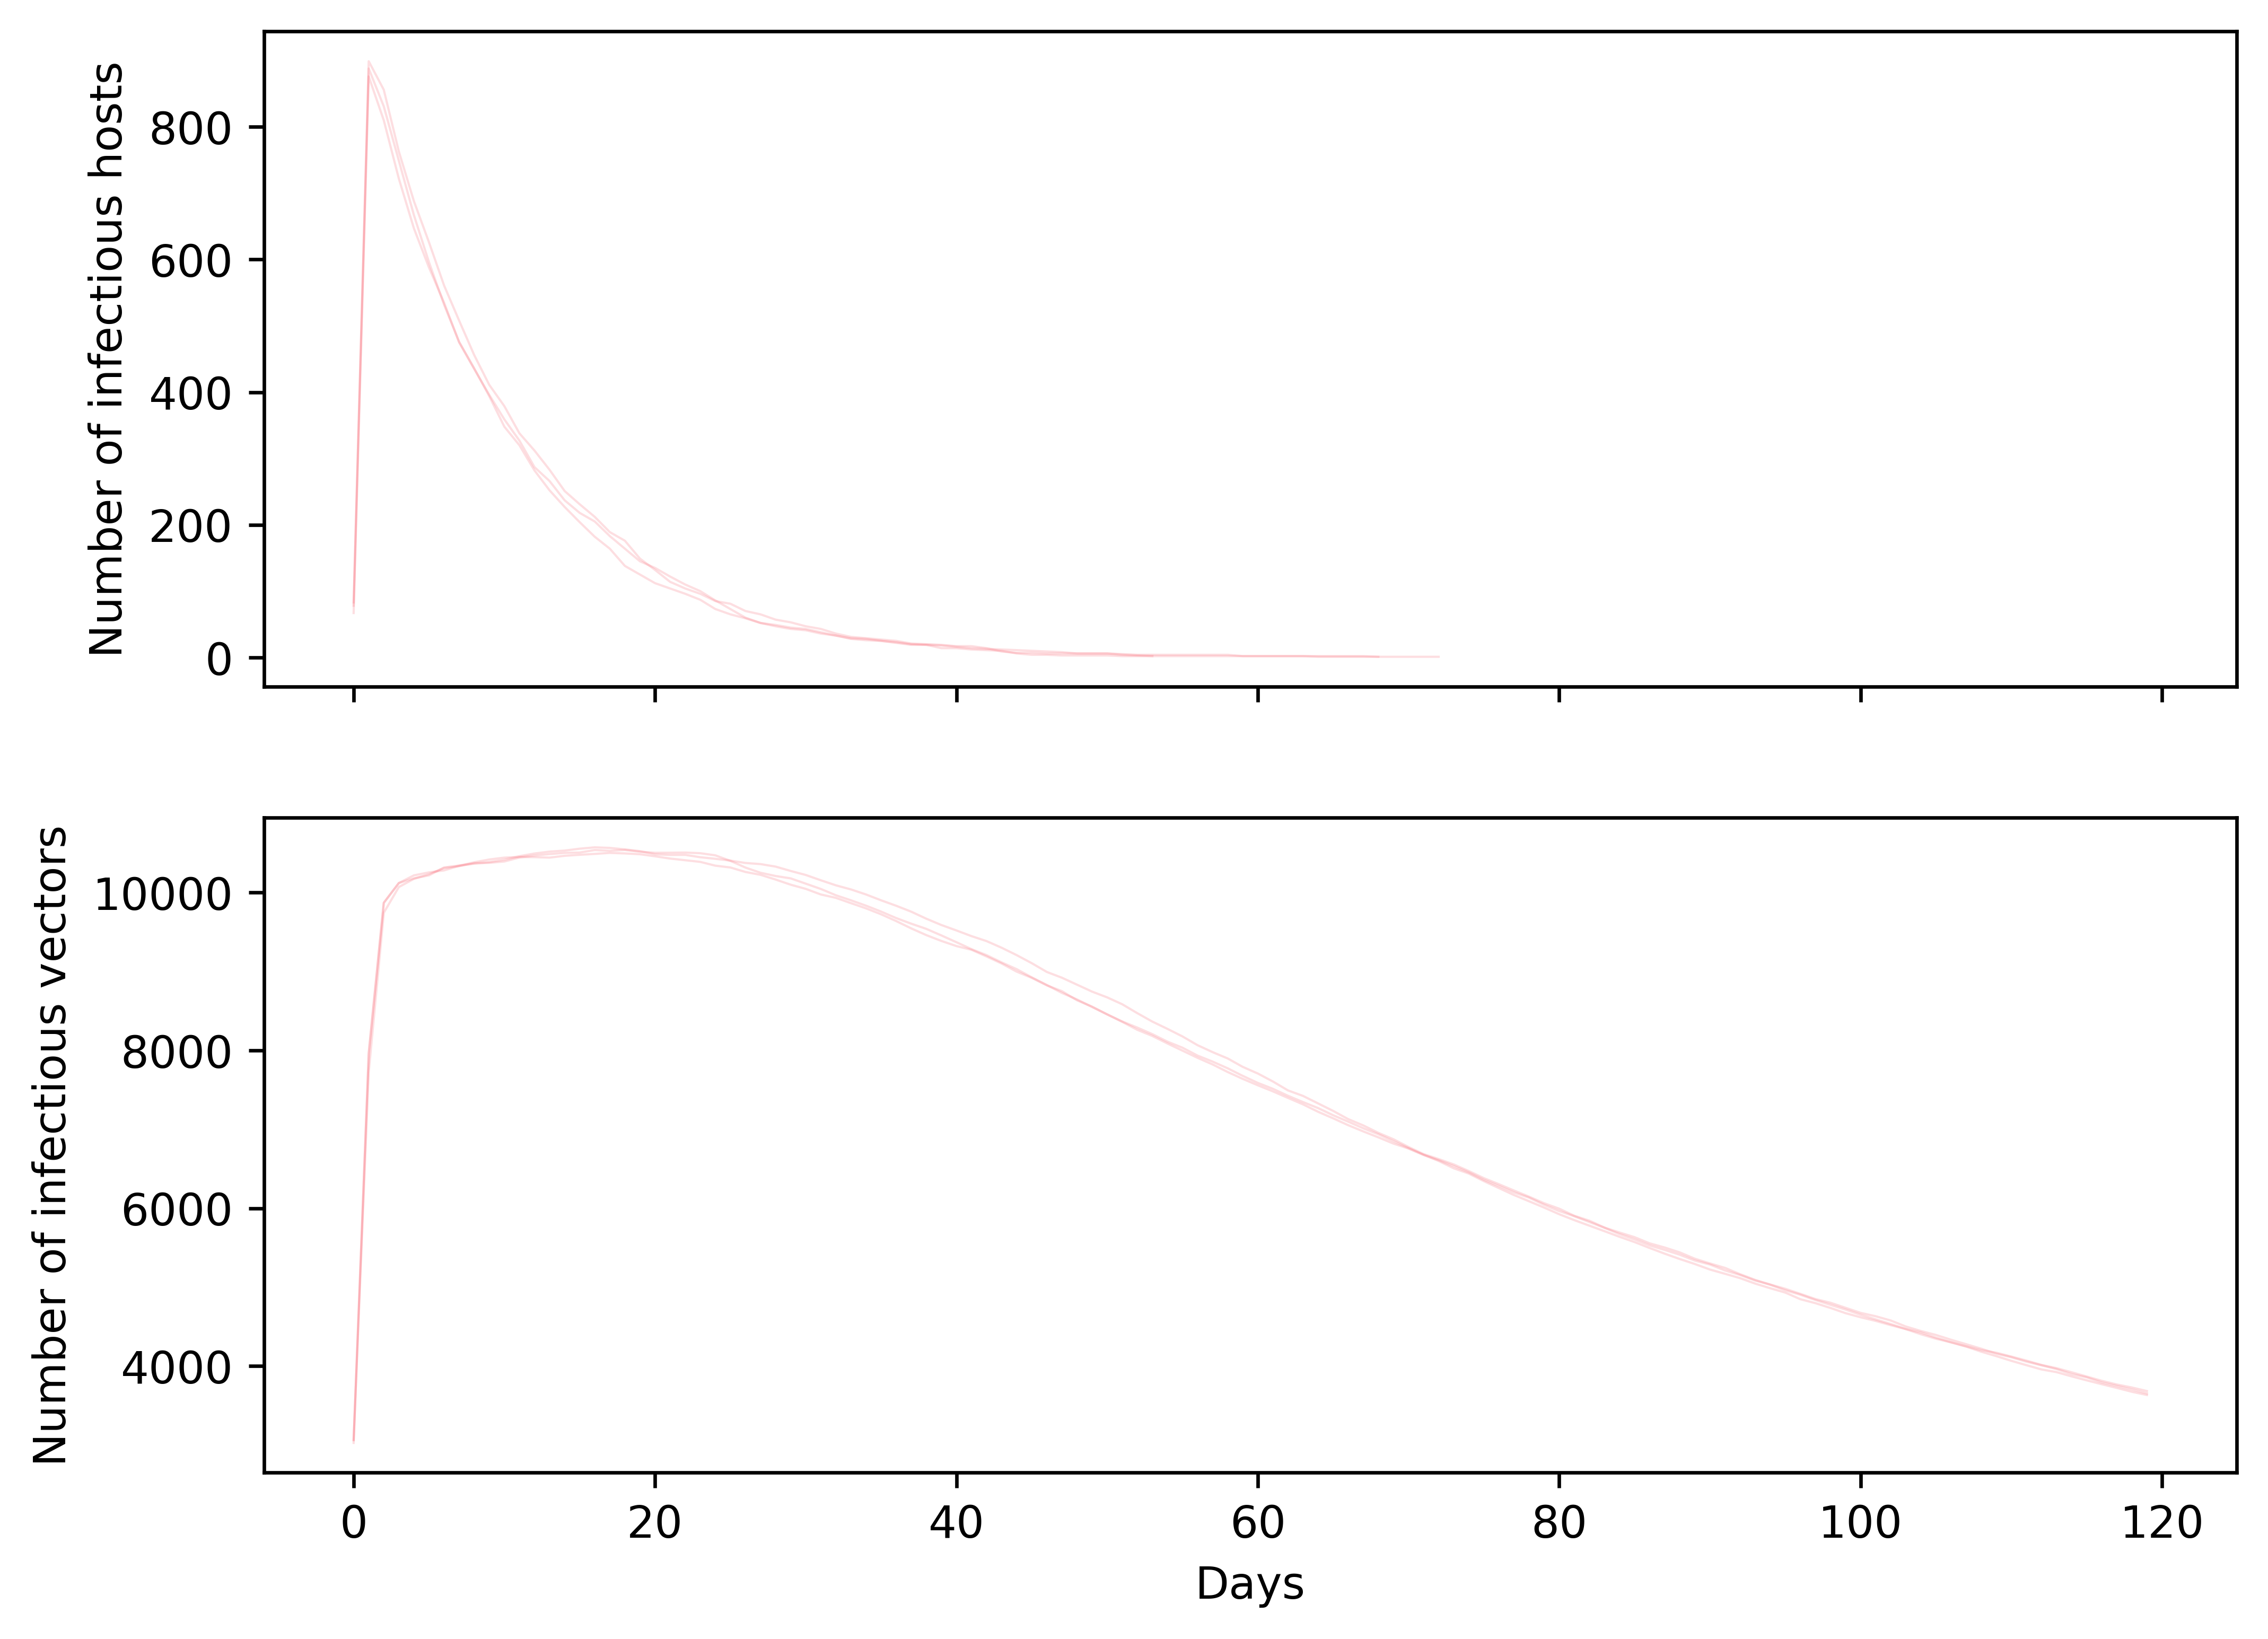

In [9]:
fig, axs = plt.subplots(nrows=2, ncols=1, sharex=True, facecolor="w", figsize=(8, 6), dpi=600)

axs[0].plot(host_df, color=COLORS["I"], alpha=0.2, lw=0.5)
axs[0].set_ylabel("Number of infectious hosts")

axs[1].plot(vector_df, color=COLORS["I"], alpha=0.2, lw=0.5)
axs[1].set_xlabel("Days")
axs[1].set_ylabel("Number of infectious vectors")